# Charge profile optimization - M1

Ref: Hoke 2011 [Electric Vehicle Charge Optimization Including
Effects of Lithium-Ion Battery Degradation]

Using a linear solver (namely: GLOP) to solve for optimized charge profile based on electricity costs.
Linear optimization does not allow for adequate accounting of the battery degradation as a function of absolute power charge and in this model we do not allow for V2G charge (for this, see model 2) 

Model 1:
- An electric vehicle (EV) can charge within a time window (t_min;t_max), from a charge infrastructure with varying electricity prices.

Key observations:
 - In this simple model, the charge occurs at lowest electricity prices possible to minimze the costs of electricity. 

In [14]:
import ortools
import numpy as np
from ortools.linear_solver import pywraplp
import seaborn as sns; sns.set_style("whitegrid");

In [10]:
# Electricity market

TIME_PERIOD_HOURS = 24 # starts at noon=0
# Costs based on approximation of EDF's "Tarif Bleu", august 2020 (https://www.jechange.fr/energie/electricite/guides/prix-electricite-kwh-2435)
LOW_COST = 0.1377
HIGH_COST = 0.1781
ELECTRICITY_COSTS = [LOW_COST]*5 + [HIGH_COST]*4 + [LOW_COST]*10 + [HIGH_COST]*5  # 12h-17h, 17h-21h, 21h-7h, 7H-12h

# TODO: think about replacing by a function to allow for more temporal granularity

# Vehicle

STATE_OF_CHARGE_T0 = 0.30
STATE_OF_CHARGE_TCH = 0.90
Q_KWH = 30

# Charge system

CHARGE_POWER_LOWER_BOUND_KWH = 0 # negative would allow V2H transfer
CHARGE_POWER_HIGHER_BOUND_KWH = 6.6

# User
T_MIN = 1 # vehicle is plugged
T_MAX = 22  # Vehicle to be charged before T_MAX pm (if T_MAX<=12)

[Text(0.5, 0, 'Time (hours, 0=noon)'),
 Text(0, 0.5, 'Electricity price (euros)')]

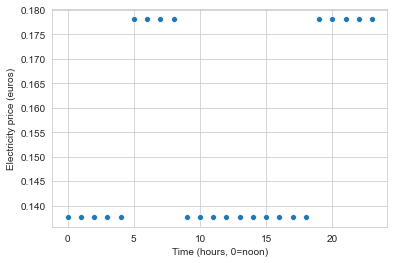

In [11]:
ax = sns.scatterplot(range(24), ELECTRICITY_COSTS)
ax.set(xlabel='Time (hours, 0=noon)', ylabel='Electricity price (euros)')

In [12]:
# optimization 

solver = pywraplp.Solver.CreateSolver('simple_lp_program', 'GLOP')
# create charge power variables for each time of day
variables = []
for i in range(24):
    if (i < T_MIN) or  (T_MAX <= i):
        p = solver.NumVar(0, 0, 'p{}'.format(i))
    else:
        p = solver.NumVar(CHARGE_POWER_LOWER_BOUND_KWH, CHARGE_POWER_HIGHER_BOUND_KWH, 'p{}'.format(i))
    variables.append(p)

# create constraint that vehicle is to be charged (>90% of Q) before t_max
ct_charge_vehicle_before_tmax = solver.Constraint(Q_KWH*(STATE_OF_CHARGE_TCH - STATE_OF_CHARGE_T0), 
                                                  Q_KWH*(1-STATE_OF_CHARGE_T0), 
                                                  'ct_charge_vehicle_before_tmax')
for variable in variables[:T_MAX]:
    ct_charge_vehicle_before_tmax.SetCoefficient(variable, 1)

# create constraint of bounded charge at each time
for i in range(1,25):
    ct_bounded_charge = solver.Constraint(- Q_KWH*STATE_OF_CHARGE_T0,
                                          Q_KWH*(1-STATE_OF_CHARGE_T0),
                                          'ct_bounded_charge')
    for variable in variables[:i]:
        ct_bounded_charge.SetCoefficient(variable, 1)

# set the objective: minimizing price
objective = solver.Objective()
for i, variable in enumerate(variables):
    objective.SetCoefficient(variable, ELECTRICITY_COSTS[i])
objective.SetMinimization()

# solve
solver.Solve()
print('Optimal charge profile (kWh):')
solution = [variable.solution_value() for variable in variables]
print(solution)
print('Resulting vehicle charge (kWh)')
print(np.cumsum(solution) + Q_KWH*STATE_OF_CHARGE_T0)
print('Total balance = {}€'.format(round(objective.Value(),4)))


Optimal charge profile (kWh):
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.800000000000004, 6.6, 6.6, 0.0, 0.0, 0.0, 0.0, 0.0]
Resulting vehicle charge (kWh)
[ 9.   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.   9.
  9.   9.  13.8 20.4 27.  27.  27.  27.  27.  27. ]
Total balance = 2.4786€


[Text(0.5, 0, 'Time (hours, 0=noon)'), Text(0, 0.5, 'Power charge (kWh)')]

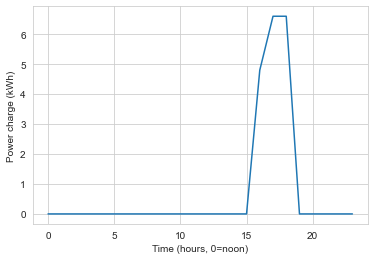

In [13]:
ax = sns.lineplot(range(24), solution)
ax.set(xlabel='Time (hours, 0=noon)', ylabel='Power charge (kWh)')